In [1]:
# IMPORTS ****************************************************

import numpy as np
import math
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import skimage as sk
import skimage.io as skio
from skimage import feature
import time

In [2]:
# 0. START TIMER ****************************************************

start_time = time.time()

In [3]:
# 1. USER INPUT - (DEFINE MODEL PARAMS) ****************************************************

# a. choose search displacement range (15x15 pixel default - works best)
search = 15

# b. choose image to colorize
name = "village"

# c. define crop amount (% of overall image width / height)
crop_amount = 5

# d. select depth for multi-search (Default = 4 - works best)
depth = 4

# e. Define image path
img_path = "data/plates_original_size/"

In [4]:
# # 2. DEFINE IMAGE PATH ****************************************************

image_choice = f"{name}.tif"
file_name = f"{image_choice}_1"
img_name = image_choice
image_Z = skio.imread(img_path+img_name)

In [5]:
# 3. GET IMAGE DIMENSIONS ****************************************************

# original dimensions
original_height = image_Z.shape[0]
original_width = image_Z.shape[1]

# reduced dimensions
reduc_height = int(original_height / 3)
reduc_width = int(original_width)

In [6]:
# 4. SEPERATE COLOR CHANNEL IMAGES ****************************************************

blue_channel = image_Z[:reduc_height]
green_channel  = image_Z[reduc_height: 2*reduc_height]
red_channel = image_Z[2*reduc_height: 3*reduc_height]

In [7]:
# 5. CROP IMAGE BORDERS ****************************************************

# Set crop amounts per side
crop_height = int(reduc_height * (crop_amount/100))
crop_width = int(reduc_width * (crop_amount/100))

# assign to variables
left_crop = crop_width
right_crop = reduc_width - crop_width
top_crop = crop_height
bottom_crop = reduc_height - crop_height

# crop all color channel images
red_channel = red_channel[top_crop:bottom_crop, left_crop:right_crop]
blue_channel = blue_channel[top_crop:bottom_crop, left_crop:right_crop]
green_channel = green_channel[top_crop:bottom_crop, left_crop:right_crop]

In [8]:
# 6. FIND ALIGNMENT USING NCC FUNCTION ****************************************************

# Overview
#    - Normalized Cross Correlation (NCC) score will be used to determine the best 
#      image shift / displacement to align images
#    - This function finds best shifts for both green & red channel images
#    - NCC is simply the dot product between two normalized vectors.


def NCC(red_channel, green_channel, blue_channel, search):
    
    # FIND NCC - GREEN CHANNEL

    # a. Create list of all shift possibilities
    # Cycle through all possible x & y shifts and store in list
    
    axis_shift_list = []
    
    for x_axis in range (-search,search+1):
        for y_axis in range(-search,search+1):         
            shift = [x_axis, y_axis]
            axis_shift_list.append(shift)

    # b. Create list of shifted image arrays per shift possibilities
    # Apply np.roll function to create all shift possibilities
    # per https://numpy.org/doc/stable/reference/generated/numpy.roll.html
    
    green_shift_list = []
    
    for shift in axis_shift_list:  
        green_shift_list.append(np.roll(green_channel, 
                                shift, 
                                axis = (0,1)))

    # c. Create list of NCC Scores of all shifted images
    # Determine which green shift image has the best NCC score when compared to blue_channel image

    NCC_scores = []

    for green_shift_image in green_shift_list:

        # Normalize both green_shift_image & blue_channel image.
        # Per https://www.kite.com/python/answers/how-to-normalize-an-array-in-numpy-in-python
        
        green_shift_image_norm = np.linalg.norm(green_shift_image)
        blue_channel_norm = np.linalg.norm(blue_channel)

        # Flatten arrays
        # per https://xcdskd.readthedocs.io/en/latest/cross_correlation/cross_correlation_coefficient.html
        
        green_shift_1D = np.ravel(green_shift_image)
        blue_channel_1D = np.ravel( blue_channel)

        # Find NCC via dot product between the two normalized vectors and add to NCC_scores list
        # per https://numpy.org/doc/stable/reference/generated/numpy.dot.html
        
        NCC_scores.append(np.dot(green_shift_1D/green_shift_image_norm, 
                                blue_channel_1D/blue_channel_norm))

    # d. Find max score & return corresponding x,y axis
    
    max_NCC = max(NCC_scores)
    max_index = NCC_scores.index(max_NCC) 

    final_shift = axis_shift_list[max_index]
    green_displacement = final_shift

    print(max_NCC)
    print(axis_shift_list[max_index])

    # e. Transform green_channel image to match best shift
    
    green_shift_final = np.roll(green_channel,
                              final_shift,
                              axis = (0,1))






    # FIND NCC - RED CHANNEL

    # a. Create list of all shift possibilities
    # Cycle through all possible x & y shifts and store in list
    
    axis_shift_list = []

    for x_axis in range (-search,search+1):
        for y_axis in range(-search,search+1):
            shift = [x_axis, y_axis]
            axis_shift_list.append(shift)

    # b. Create list of shifted image arrays per shift possibilities
    # Apply np.roll function to create all shift possibilities
    # per https://numpy.org/doc/stable/reference/generated/numpy.roll.html
    
    red_shift_list = []

    for shift in axis_shift_list:
        red_shift_list.append(np.roll(red_channel, 
                                shift, 
                                axis = (0,1)))

    # c. Create list of NCC Scores of all shifted images
    # Determine which green shift image has the best NCC score when compared to blue_channel image
    
    NCC_scores = []

    for red_shift_image in red_shift_list:

        # Normalize both red_shift_image & blue_channel image.
        # Per https://www.kite.com/python/answers/how-to-normalize-an-array-in-numpy-in-python
        
        red_shift_image_norm = np.linalg.norm(red_shift_image)
        blue_channel_norm = np.linalg.norm(blue_channel)

        # Flatten arrays
        # per https://xcdskd.readthedocs.io/en/latest/cross_correlation/cross_correlation_coefficient.html 
        
        red_shift_1D = np.ravel(red_shift_image)
        blue_channel_1D = np.ravel(blue_channel)

        # Find NCC via dot product between the two normalized vectors and add to NCC_scores list
        # per https://numpy.org/doc/stable/reference/generated/numpy.dot.html
        
        NCC_scores.append(np.dot(red_shift_1D/red_shift_image_norm, 
                                blue_channel_1D/blue_channel_norm))

    # d. Find max score & return corresponding x,y axis
    
    max_NCC = max(NCC_scores)
    max_index = NCC_scores.index(max_NCC) 

    final_shift = axis_shift_list[max_index]
    red_displacement = final_shift

    print(max_NCC)
    print(axis_shift_list[max_index])

    # e. Transform green_channel image to match best shift
    
    red_shift_final = np.roll(red_channel,
                              final_shift,
                              axis = (0,1)) 
    
    # f. Return Values
    
    return (green_shift_final, red_shift_final, red_displacement, green_displacement)

In [9]:
# 7. CREATE PYRAMID IMAGE ALIGNMENT SHIFT LISTS ****************************************************

Green_shift_X = []
Green_shift_Y = []

Red_shift_X = []
Red_shift_Y = []

In [10]:
# 7. CREATE IMAGE PYRAMID FUNCTION ****************************************************

# -  Below algorithm uses a recursive function to sequentially reduce the size
#   of the image by 1/2, four times in a row, thus generating a 4 level image pyramid.  
# - This four level pyramid allows for a very fast alignment process as the majority
#   of alignment searching takes place on the smaller images. This returns the majority of
#   the alignment shifts required to best align photos.
# - As the image gets bigger, the searchable region amount is reduced so less alignment 
#   searching is needed to be done, thus reducing the number of operations taking place
#   on larger images and thus preventing slower operations.
# - The reduced searching on larger images requires less memory and processing power and 
#  returns smaller image alignment shifts.  Though smaller, these adjustments do
#  provide a level of "fine tuning" which helps to create a sharper image.


def Image_pyramid(red_chan, green_chan, blue_chan, depth):
    
    if depth == 0:
        
        # reduces image search displacement shift by 0.5 as image gets larger
        # therefore algorithm will search larger areas for small images
        # and smaller areas for large image, thus increasing speed.
        
        disp = int(search / (2**(4-depth)))
        
        return NCC(red_chan, green_chan, blue_chan, disp)
    
    
    else: 
        
        # Scale images by 0.5**depth for each level of pyramid
        # - Starting from top of pyramid and moving down
        
        red_reduced = sk.transform.rescale(red_chan, 0.5**depth)
        blue_reduced = sk.transform.rescale(blue_chan, 0.5**depth)
        green_reduced = sk.transform.rescale(green_chan, 0.5**depth)
        
        
        # Adjust image displacement search area per current pyramid level
        # - reduces image search displacement shift by 0.5 as image gets larger
        # - therefore algorithm will search larger areas for small images
        #   and smaller areas for large image, thus increasing speed.
        
        disp = int(search / (2**(4-depth)))
        
        # apply adjusted image displacement search area to NCC algorithm
        # apply reduced image sizes to NCC algorithm to find best image shift amount
        
        g_sm, r_sm, r_shft, g_shft = NCC(red_reduced, green_reduced, blue_reduced, disp)
        
        # Once image shifts found with NCC Algorithm, upscale
        # - This will scale up x,y axis shift so it can be applied to original image size
        
        r_shft[0] = int(r_shft[0]*(2**depth))
        r_shft[1] = int(r_shft[1]*(2**depth))
        
        g_shft[0] = int(g_shft[0]*(2**depth))
        g_shft[1] = int(g_shft[1]*(2**depth))
        
        # Add upscaled shifts to counter so they can be added together
        # - Final tally will let us know how much images were shifted in total
        
        Green_shift_X.append(g_shft[0])
        Green_shift_Y.append(g_shft[1])
        Red_shift_X.append(r_shft[0])
        Red_shift_Y.append(r_shft[1])
        
        
        # Shift orginal image based on pyramid specific shift step via NCC algorithm results
        
        red_roll = np.roll(red_chan,
                              r_shft,
                              axis = (0,1)) 
        
        green_roll = np.roll(green_chan,
                              g_shft,
                              axis = (0,1)) 
        
        # Send newly shifted full-size images into next phase of image pyramid for
        # finer shift adjustments
        
        return Image_pyramid(red_roll, green_roll, blue_chan, depth-1)    

In [11]:
# 8. ASSIGN IMAGE_PYRAMID RESULTS TO VARIABLES  ****************************************************

green_shift_final, red_shift_final, red_displacement, green_displacement = Image_pyramid(red_channel, green_channel, blue_channel, depth)

0.9849261292487681
[4, 0]
0.9668609023025391
[8, 1]
0.9841234361708421
[0, 1]
0.9664304144685566
[1, 0]
0.9826909725733729
[0, 1]
0.9650202397863948
[0, 1]
0.9813856430392097
[0, -1]
0.9639438652201158
[1, 1]
0.9806813523241542
[0, 0]
0.963390458224313
[0, 0]


In [12]:
# 9. STACK FINAL SHIFTED IMAGES ****************************************************

im_out = np.dstack((red_shift_final, green_shift_final, blue_channel))

In [13]:
# 10. SAVE FINAL IMAGE ****************************************************

fname = f'{name}_NCC_Test_{search}.jpg'
skio.imsave(fname, im_out)

Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.


In [14]:
# 12. END TIMER ****************************************************

end_time = time.time()

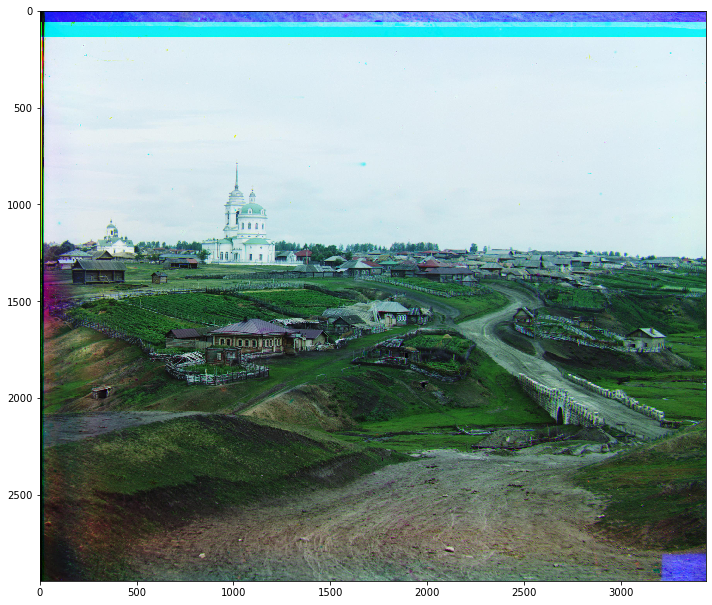

Total time = 11.143739223480225 seconds
Green channel shift = [64, 10]
Red channel shift = [138, 22]


In [15]:
# 12. DISPLAY FINAL IMAGE & IMAGE SHIFT & TIME ****************************************************

plt.figure(figsize = (10,10))
skio.imshow(fname)
skio.show()

Green_Shift = f'Green channel shift = {[sum(Green_shift_X),sum(Green_shift_Y)]}'
Red_Shift = f'Red channel shift = {[sum(Red_shift_X),sum(Red_shift_Y)]}'
total_time = end_time - start_time

print(f'Total time = {total_time} seconds')
print(Green_Shift)
print(Red_Shift)